In [1]:
import numpy as np
import matplotlib.pyplot as plt
from h5py import File

from astropy import units as u, constants as const
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM

SPEED_OF_LIGHT = const.c.to_value(u.km / u.s)  # km / s
FNAME = "/Users/rstiskalek/Downloads/top5000_halos_train.hdf5"
BOXSIZE = 1000 # Mpc / h

%matplotlib inline

In [ ]:
def load_catalog(num):
    with File(FNAME, 'r') as f:
        grp = f[f"BSQ/BSQ_{num}"]
        pos = np.vstack([grp[p] for p in ['X', 'Y', 'Z']]).T
        vel = np.vstack([grp[v] for v in ['VX', 'VY', 'VZ']]).T
        Mvir = grp['Mvir'][...]

        grp = f[f"params"]
        cosmo = {k: grp[k][num] for k in ['h', 'Omega_m', 'Omega_b', 'sigma_8', 'n_s']}

    cosmo = FlatLambdaCDM(
        H0=100 * cosmo["h"],
        Om0=cosmo["Omega_m"],
        Ob0=cosmo["Omega_b"],
    )

    return pos, vel, Mvir, cosmo


def center_at_observer(pos, boxsize, obs):
    return (pos - obs + boxsize / 2) % boxsize


def real2redshift(pos, vel, obs_pos, boxsize, cosmo):
    pos_here = center_at_observer(pos, boxsize, obs_pos)
    pos_here -= boxsize / 2  # center at observer

    # Radial distance and unit vector to each halo
    r = np.linalg.norm(pos_here, axis=1)
    rhat = pos_here / r[:, None]

    # Angles on the sky
    theta = np.arccos(rhat[:, 2])  # polar angle
    phi = np.arctan2(rhat[:, 1], rhat[:, 0])  # azimuthal angle
    phi = (phi + 2 * np.pi) % (2 * np.pi)  # [0, 2pi]

    RA = np.rad2deg(phi)
    DEC = 90 - np.rad2deg(theta)

    # Line-of-sight velocity
    v_los = np.sum(vel * rhat, axis=1)
    # Mapping from the real-space distance to cosmological redshift
    zgrid = np.linspace(0, 1.0, 10_000)
    rgrid = cosmo.comoving_distance(zgrid).to_value(u.Mpc) * cosmo.h  # Mpc / h
    zcosmo = interp1d(rgrid, zgrid, bounds_error=True)(r)

    zobs = (1 + zcosmo) * (1 + v_los / SPEED_OF_LIGHT) - 1
    czobs = SPEED_OF_LIGHT * zobs

    czcosmo = SPEED_OF_LIGHT * zcosmo

    return czobs, RA, DEC, czcosmo, v_los

    
def pos_redshift_space(pos, vel, boxsize, hubble, redshift, axis):
    factor = (1.0 + redshift) / hubble
    pos[:, axis] += vel[:, axis] * factor
    pos[:, axis] %= boxsize
    return pos


In [209]:
pos, vel, Mvir, cosmo = load_catalog(10)
obs = np.asarray([500, 500, 500])  # Mpc / h


czobs, RA, DEC, czcosmo, v_los = real2redshift(pos, vel, obs, BOXSIZE, cosmo)


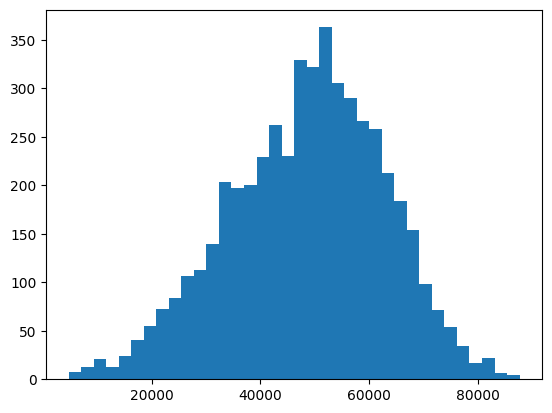

In [210]:
plt.figure()
plt.hist(czobs, bins="auto")
plt.show()

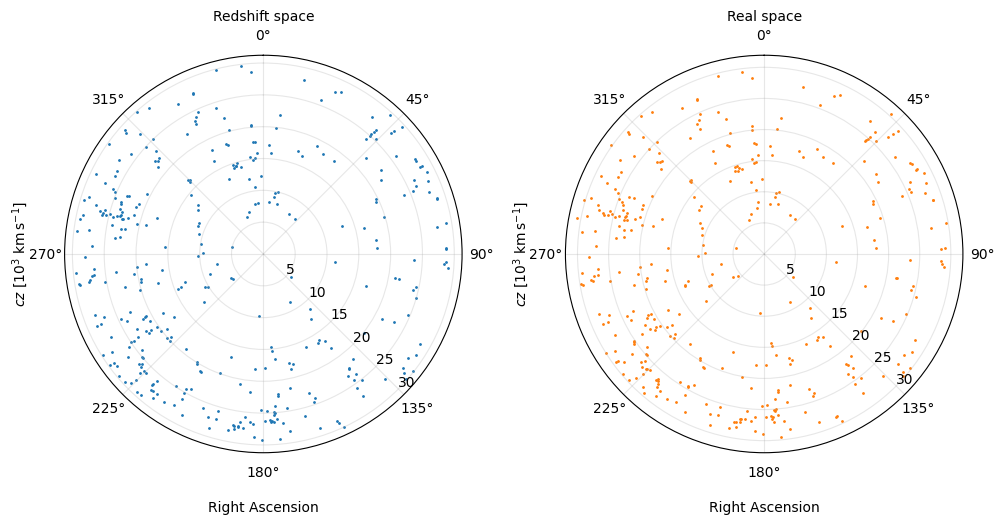

In [211]:
m = (DEC > -40) & (DEC < 40) & (czobs < 30_000)
phi = np.deg2rad(RA[m])  # azimuth
r_obs = czobs[m] / 1000.0
r_real = czcosmo[m] / 1000.0

fig, axs = plt.subplots(
    1, 2, figsize=(10, 5),
    subplot_kw={"projection": "polar"},
    constrained_layout=True,
)

# --- Redshift space ---
axs[0].scatter(phi, r_obs, s=1, color="C0", rasterized=True)
axs[0].set_title("Redshift space", fontsize=10)

# --- Real space ---
axs[1].scatter(phi, r_real, s=1, color="C1", rasterized=True)
axs[1].set_title("Real space", fontsize=10)

# Shared axis formatting
for ax in axs:
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_thetamin(0)
    ax.set_thetamax(360)
    ax.set_rlabel_position(135)
    ax.grid(alpha=0.3)
    ax.set_xlabel(r"Right Ascension", labelpad=15)
    ax.set_ylabel(r"$cz\ [10^3\ \mathrm{km\,s^{-1}}]$", labelpad=25)

plt.show()